# RatK Day2NSD recording info

In [4]:
import numpy as np
import subjects

sess = subjects.nsd.ratKday2[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250



## Set probe configuration
- RatK_Day2NSD had 128chans-8shank diagnostic biochip

/data/Clustering/sessions/RatK/Day2/RatK_Day2_2019-08-08_04-00-00.probegroup.npy saved


<AxesSubplot:title={'center':'Probe 128ch'}>

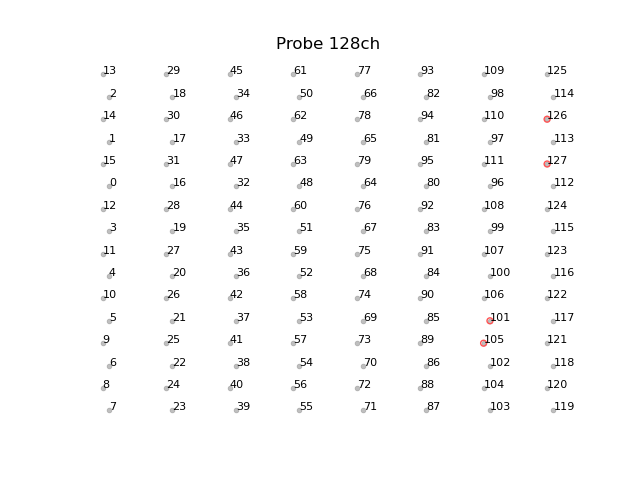

In [3]:
%matplotlib widget
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- cambridge probe -----------
for i in range(8):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=30,
        y_shift_per_column=[0,-15],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

# prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(sess.filePrefix.with_suffix('.probegroup.npy'))
plot_probe(prbgrp)



In [5]:
from neuropy.utils import probe_util

probe_util.write_spyking_circus(
    sess.filePrefix.with_suffix(".prb"),
    sess.probegroup,
    rmv_badchans=True,
    combine_shanks=True,
)


RatK_Day2_2019-08-08_04-00-00.prb file created for Spyking Circus


## Create epochs for your experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [3]:
sess.paradigm.to_dataframe()

,start,stop,label,duration
0,0.000000,10477.166632,pre,10477.166632
1,10478.166632,14238.527450,maze,3760.360818
2,14239.527450,51972.708333,post,37733.180884


In [ ]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 10000, 20000],
        "stop": [9000, 13600, 30000],
        "label": ["pre", "maze", "post"],
    }
)

a = Epoch(epochs=epochs)
a.filename = sess.filePrefix.with_suffix(".paradigm.npy")
# a.save()


# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
pbe.filename = sess.filePrefix.with_suffix(".pbe")
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
pbe.filename = sess.filePrefix.with_suffix(".pbe")
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Importing spiketrains from Phy

In [3]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatK/Day2/spykcirc/RatK_Day2_2019-08-08_04-00-00/RatK_Day2_2019-08-08_04-00-00.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neuron_type_id = phy_data.cluster_info.q.values
neuron_type = np.ones(len(neuron_type_id), dtype="U5")
neuron_type[neuron_type_id<4] = 'pyr'
neuron_type[neuron_type_id==6] = 'mua'
neuron_type[neuron_type_id==8] = 'inter'


neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int),
    neuron_type=neuron_type
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()

RatK_Day2_2019-08-08_04-00-00.neurons saved


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

# BinnedSpiketrain and Mua objects using Neurons

In [8]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


data saved


In [10]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
# plotting.plot_mua(smth_mua)

In [11]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()

/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


data saved
